In [1043]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')

import numpy as np
import scipy.stats as stats
import pandas as pd

from scipy.spatial import distance
from sklearn.cluster import SpectralBiclustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import random
from collections import Counter
import json
import re
import ast

import importlib

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import pickle
import nltk

import drawing_utils as drawing
import block_construction_helpers as bc

In [2]:
experiment_name = 'perceptual_chunks'

## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

# paths to silhouette data
silhouette_results_dir = os.path.join(results_dir, 'silhouette')
silhouette_csv_dir = os.path.join(silhouette_results_dir,'csv')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [3]:
# latest iteration name to include
iteration_name = 'pilot_0c'
iteration_names = ['pilot_0','pilot_0b','pilot_0c']

# variables to check integrity of data
numTrials = 8

In [4]:
# open pickled dataframes

trial_path_p = os.path.join(csv_dir,'perceptual_chunks_trial_{}.p'.format(iteration_name))
df_perc_trial = pickle.load( open(trial_path_p, "rb" ))

# not used in this analysis
# color_path_p = os.path.join(csv_dir,'perceptual_chunks_color_{}.p'.format(iteration_name))
# df_color = pickle.load( open(color_path_p, "rb" ))

In [5]:
# filter participant that didn't follow instructions
df_perc_trial = df_perc_trial[df_perc_trial.flag=='none']
# df_color = df_color[df_perc_trial.flag=='none']

In [6]:
# useful vars
ppts = np.sort(df_perc_trial.gameID.unique())
targets = np.sort(df_perc_trial.targetName.unique())
n_ppt = len(ppts)
print(str(n_ppt) + ' ppts loaded')

49 ppts loaded


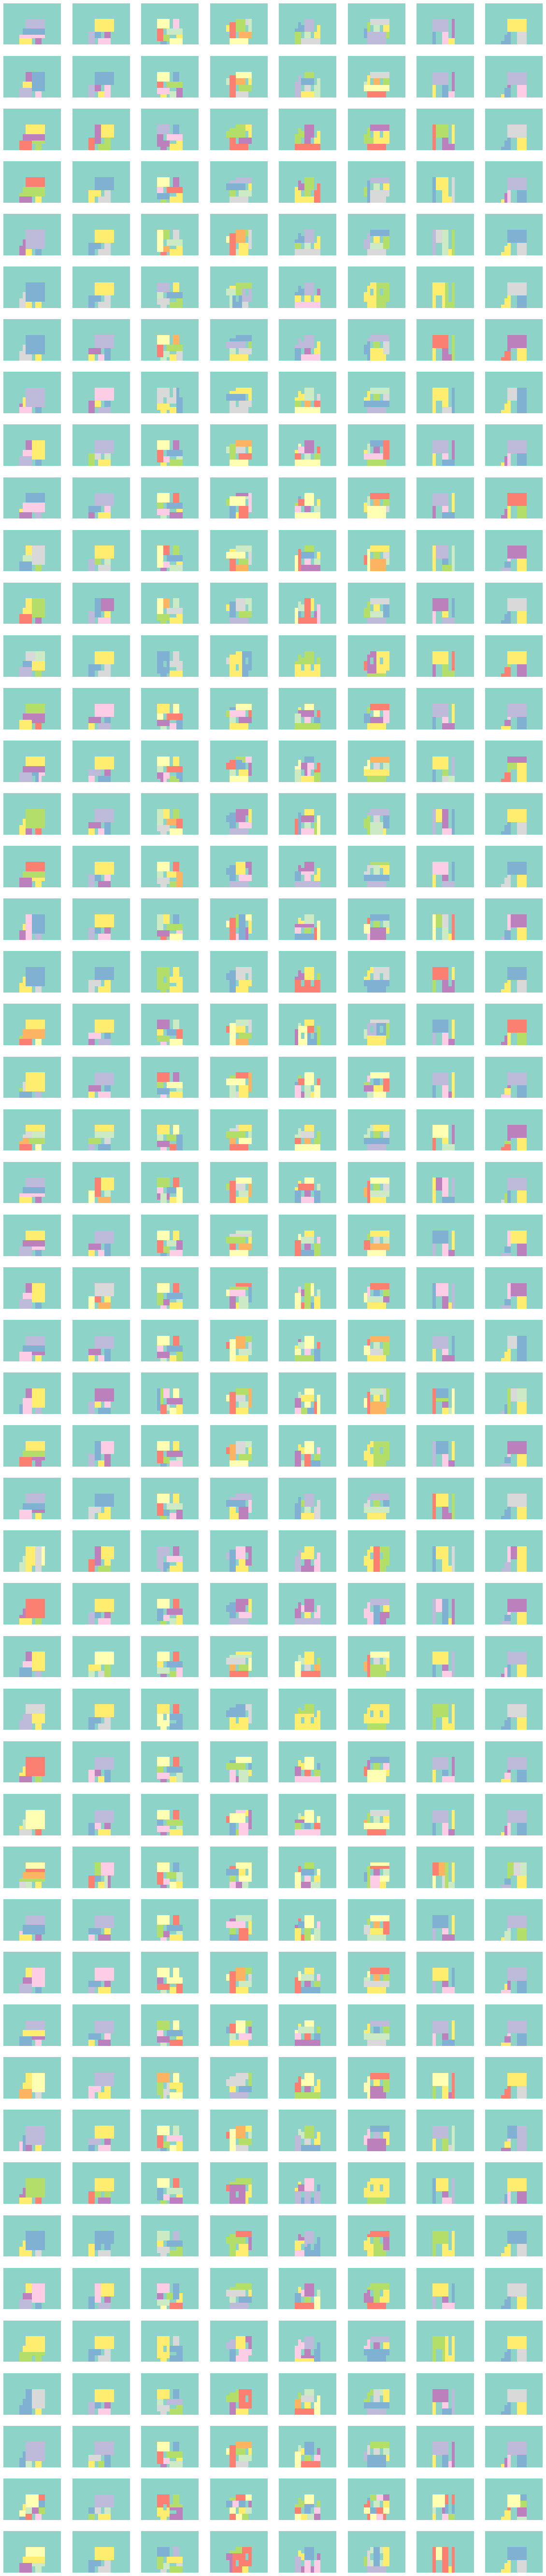

In [7]:
# visualize all participant's chunks

visualize = True

if visualize:

    fig, axs = plt.subplots(n_ppt, numTrials, figsize=(20,2*n_ppt))

    for i, ppt in enumerate(ppts):

        for j, target in enumerate(targets):

            chunks = df_perc_trial[(df_perc_trial.gameID==ppt) & (df_perc_trial.targetName==target)]['gameGrid'].iloc[0]
            chunks = np.rot90(chunks)
            axs[i,j].axis('off')
            axs[i,j].imshow(chunks, cmap='Set3')

### Define useful functions

In [8]:
def find_world_diffs(df_proc_world_states, window_sizes = range(2,10)):
    '''
    Find all chunks for all structures (so we can search for the structures that involve this chunk)

    a 'window-size' is the amount of states between first and final one considered INCLUSIVE. i.e. n is n-1 actions.
    i.e. window size 3 means 2 consecutive actions
    '''

    df_target_grouped = df_proc_world_states.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

    df_world_deltas = df_proc_trial.copy()

    for chunk_size in window_sizes:

        # for each reconstruction, get a list of ngrams of that length
        df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

        # find the chunks (world deltas) from those ngrams   
        df_ngrams['world_diff'] = df_ngrams['flatDiscreteWorldStr'].apply(lambda ngrams:
                                         ["".join([str(int(a)) for a in 
                                          list(
                                              np.logical_xor(np.array(list(ngram[-1])).astype(np.bool), 
                                              np.array(list(ngram[0])).astype(np.bool))
                                              )])
                                         for ngram in ngrams])

        df_ngrams = df_ngrams.rename(columns={"flatDiscreteWorldStr": str(chunk_size)+'_grams',
                                              "world_diff": str(chunk_size)+'_chunks'})

        df_world_deltas = df_world_deltas.merge(df_ngrams, how='left', on=['gameID','targetName','phase_extended'])
        
    # combine chunks from all window sized into list, so we can search for chunks in the entire reconstruction
    df_world_deltas['all_chunks'] = df_world_deltas[[(str(chunk_window)+'_chunks') \
                        for chunk_window in window_sizes if (str(chunk_window)+'_chunks') in df_world_deltas.columns]]\
    .apply(lambda row: [chunk for chunks in list(row) for chunk in chunks], axis=1)


    return df_world_deltas

In [9]:
def find_perc_chunks_in_procedures(perceptual_chunk_counters, 
                                   df_proc_chunks,
                                   min_count = 0):
    '''
    construct a new dataframe, searching for chunks 
    '''

    occurrences_in_procedures = pd.DataFrame()

    for target in targets:
        
        for i, (chunk_str, count) in enumerate(perceptual_chunk_counters[target].items()):

            if count >= min_count:

                props = {}

                for phase in ['pre','post']:
                    
                    subset_for_target = df_proc_chunks[(df_proc_chunks.blockFell == False) &
                                                       (df_proc_chunks.targetName == target) &
                                                       (df_proc_chunks.phase == phase)]

                    # check all precomputed chunks (of window sizes selected above) for presence of chunk
                    subset_with_chunk = subset_for_target[(subset_for_target['all_chunks']\
                                                           .apply(lambda chunks: chunk_str in chunks))]
                    
                    chunk_array = bc.chunk_str_to_cropped_array(chunk_str)
                    
                    
                    
                    if subset_with_chunk.shape[0]:
                        n_with_chunk = subset_with_chunk.shape[0]
                        props[phase] = subset_with_chunk.shape[0] / subset_for_target.shape[0]
                    else:
                        n_with_chunk = 0
                        props[phase] = 0

                    row = {
                        'targetName': target,
                        'phase': phase,
                        'chunk_str': chunk_str,
        #                 'reconstructions_with_chunk': list(subset_with_chunk['discreteWorld']),
                        'total_phase_reconstructions': subset_for_target.shape[0],
                        'n_with_chunk': n_with_chunk,
                        'chunk_height': np.sum(np.dot(np.sum(chunk_array, axis=0),np.arange(8)))/np.sum(chunk_array) + 0.5,
                        'proportion_with_chunk': props[phase],
                        'perceptual_count': count,
                        'perceptual_rank': i

                    }

                    occurrences_in_procedures = occurrences_in_procedures.append(row, ignore_index=True)

                occurrences_in_procedures.loc[(occurrences_in_procedures.targetName == target) & (occurrences_in_procedures.chunk_str == chunk_str), 'difference'] = props['post'] - props['pre']

                occurrences_in_procedures.loc[(occurrences_in_procedures.targetName == target) & (occurrences_in_procedures.chunk_str == chunk_str), 'both_zero'] = \
                    (props['pre'] == 0) & (props['post'] == 0)
                
    return occurrences_in_procedures


In [10]:
# for each structure, throw all chunks from all decompositions into a giant list
def addPerceptualChunks(chunk_list, decomposition, group_number):
    '''
    Checks whether a chunk with that group number exists in the decomposition and adds it to chunk_list 
    '''
    chunk = (decomposition==group_number)*1
    if chunk.any():
        chunk_list.append(bc.cropped_chunk_to_string(chunk))

## Properties of entire decompositions

In [11]:
# target = targets[0]

# a = np.zeros((len(ppts),len(ppts)))

# for i, ppt_i in enumerate(ppts):
#     for j, ppt_j in enumerate(ppts):
#         a[i,j] = decompositions[target][ppt_i] == decompositions[target][ppt_j]

In [12]:
# Convert each decomposition into a bag of chunks (for decomposition comparison)
# create dict of target to chunk list
decompositions = {}

for target in targets:

    decompositions[target] = {}
    
    for ppt in ppts:
        
        decompositions[target][ppt] = []
        
        for group in range(1,9):
            df_perc_trial[(df_perc_trial.targetName==target) & (df_perc_trial.gameID==ppt)].structureGrid.apply(\
                lambda decomposition: addPerceptualChunks(decompositions[target][ppt],
                                                                            decomposition,
                                                                            group))
            
        decompositions[target][ppt].sort()

# count and sort chunks
# perceptual_chunk_counters = {target: dict(Counter(perceptual_chunks[target]).most_common()) for target in targets}

In [1179]:
from scipy import stats

def sem_CI(data, confidence=0.95, ddof = 0):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a, ddof = ddof)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    print( "$%.3g$ (%.3g\\%% CI: $[%.3g, %.3g]$)" % (m, confidence*100, m-h, m+h))
    return m, m-h, m+h

def bootstrap(niter, ppts, func):
    '''
    incomplete
    '''
    sample_indices = [random.randint(0,len(ppts)-1) for i in range(0, len(ppts))]

In [1180]:
# number of unique decompositions for each target
all_decom = len(ppts) * len(targets)

unique_decom = [(len(np.unique(list(decompositions[target].values())))) for target in targets]
unique_decom

unique_decom_percent = [(len(np.unique(list(decompositions[target].values()))))/len(ppts) for target in targets]

In [1181]:
sem_CI(unique_decom)

$31.2$ (95\% CI: $[21.4, 41.1]$)


(31.25, 21.386813094843763, 41.11318690515624)

In [1182]:
sem_CI(unique_decom_percent)

$0.638$ (95\% CI: $[0.436, 0.839]$)


(0.6377551020408163, 0.43646557336415837, 0.8390446307174743)

In [1046]:
sum(unique) / all_decom


0.6377551020408163

## Popular perceptual chunks for each structure

#### dataframe

In [754]:
def chunkify_decomposition(df_perc_trial):
    
    df_chunk_properties = pd.DataFrame()
    
    for i, row in df_perc_trial.iterrows():
        for group_number in range(1,9):
            chunk = (row.structureGrid==group_number)*1
            if chunk.any():
                potential_block = bc.could_be_single_block(chunk)
                new_row = {
                    'chunk_str' : bc.cropped_chunk_to_string(chunk),
                    'chunk_array' : chunk,
                    'targetName': row.targetName,
                    'trialNum': row.trialNum,
                    'gameID': row.gameID,
                    'nChunksHighlighted': row.nChunksHighlighted,
                    'rectangular': np.bool(bc.is_rectangle(chunk)),
                    'is_block' : np.bool(potential_block[0]),
                    'which_block' : potential_block[1],
                    'height' : bc.chunk_height(chunk, chunk_is_string=False),
                    'area' : bc.chunk_area(chunk, chunk_is_string=False)
                    }
                df_chunk_properties = df_chunk_properties.append(new_row, ignore_index= True)
            
    return df_chunk_properties

df_chunk_properties = chunkify_decomposition(df_perc_trial)


In [1183]:
# mean of all chunks that are rectangular
df_chunk_properties.groupby(['targetName']).rectangular.mean()

targetName
hand_selected_004    0.852018
hand_selected_005    0.892857
hand_selected_006    0.843844
hand_selected_008    0.810000
hand_selected_009    0.722397
hand_selected_011    0.798587
hand_selected_012    0.917031
hand_selected_016    0.853659
Name: rectangular, dtype: float64

In [756]:
# mean of all **unique chunks** that are rectangular
df_chunk_properties.groupby(['targetName','chunk_str']).rectangular.first().reset_index()\
.groupby('targetName').rectangular.mean().mean()

0.6022472958328221

In [757]:
df_chunk_properties_agg = df_chunk_properties.groupby(['targetName','chunk_str']).\
                                                        agg(count=('chunk_str', 'count'), 
                                                            height=('height', 'first'), 
                                                            area=('area', 'first'),
                                                            rectangular=('rectangular','first'),
                                                            chunk_array=('chunk_array', 'first')).reset_index()

<Figure size 720x432 with 0 Axes>

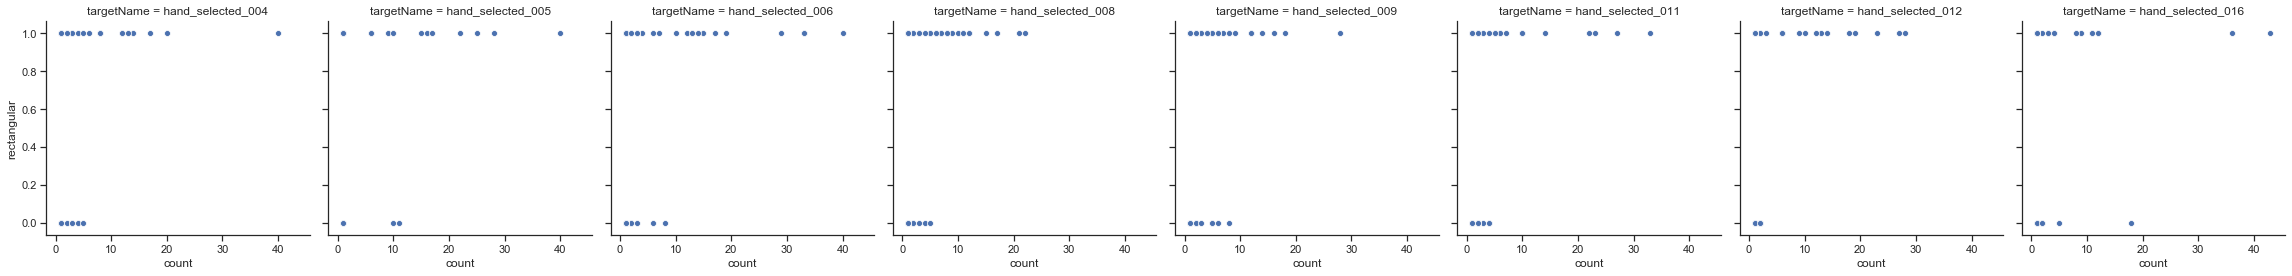

In [758]:
plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
g = sns.FacetGrid(df_chunk_properties_agg, col="targetName", height=4)
g.map(sns.scatterplot, "count", "rectangular");

In [759]:
# number of times each chunk was built
df_chunk_properties_agg.groupby(['targetName','rectangular'])['count'].mean()

targetName         rectangular
hand_selected_004  0.0             1.571429
                   1.0             5.588235
hand_selected_005  0.0             4.800000
                   1.0            11.764706
hand_selected_006  0.0             1.485714
                   1.0            11.240000
hand_selected_008  0.0             1.295455
                   1.0             5.282609
hand_selected_009  0.0             1.543860
                   1.0             4.872340
hand_selected_011  0.0             1.325581
                   1.0             4.346154
hand_selected_012  0.0             1.583333
                   1.0             7.500000
hand_selected_016  0.0             4.285714
                   1.0             6.250000
Name: count, dtype: float64

In [760]:
df_chunk_properties_agg.groupby(['targetName','rectangular'])['count'].mean().groupby('rectangular').mean()

rectangular
0.0    2.236386
1.0    7.105506
Name: count, dtype: float64

<BarContainer object of 49 artists>

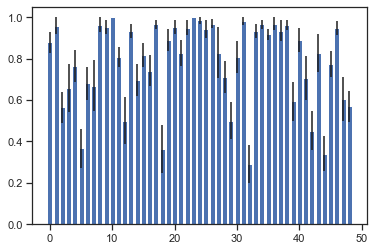

In [761]:
# looks like some ppts reliably use lots of rectangles

rect_prop = df_chunk_properties.groupby(['targetName','gameID']).rectangular.mean().groupby('gameID')

plt.bar(range(0,len(ppts)),height=rect_prop.mean(),yerr=rect_prop.std()/np.sqrt(8))

(array([ 2.,  2.,  1.,  2.,  2.,  2.,  4.,  4.,  4.,  4.,  6., 16.]),
 array([0.29166667, 0.35069444, 0.40972222, 0.46875   , 0.52777778,
        0.58680556, 0.64583333, 0.70486111, 0.76388889, 0.82291667,
        0.88194444, 0.94097222, 1.        ]),
 <a list of 12 Patch objects>)

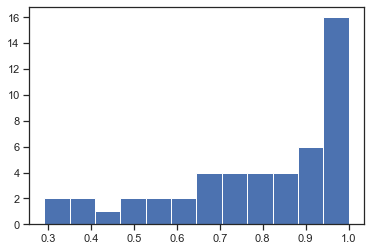

In [332]:
plt.hist(rect_prop.mean(), bins=12)

#### count dictionary

In [762]:
# Popular chunks
# create dict of target to chunk list
perceptual_chunks = {}

for target in targets:
    
    perceptual_chunks[target] = []
    
    for group in range(1,9):
        df_perc_trial[df_perc_trial.targetName==target].structureGrid.apply(\
            lambda decomposition: addPerceptualChunks(perceptual_chunks[target],
                                                                        decomposition,
                                                                        group))

# count and sort chunks
perceptual_chunk_counters = {target: dict(Counter(perceptual_chunks[target]).most_common()) for target in targets}

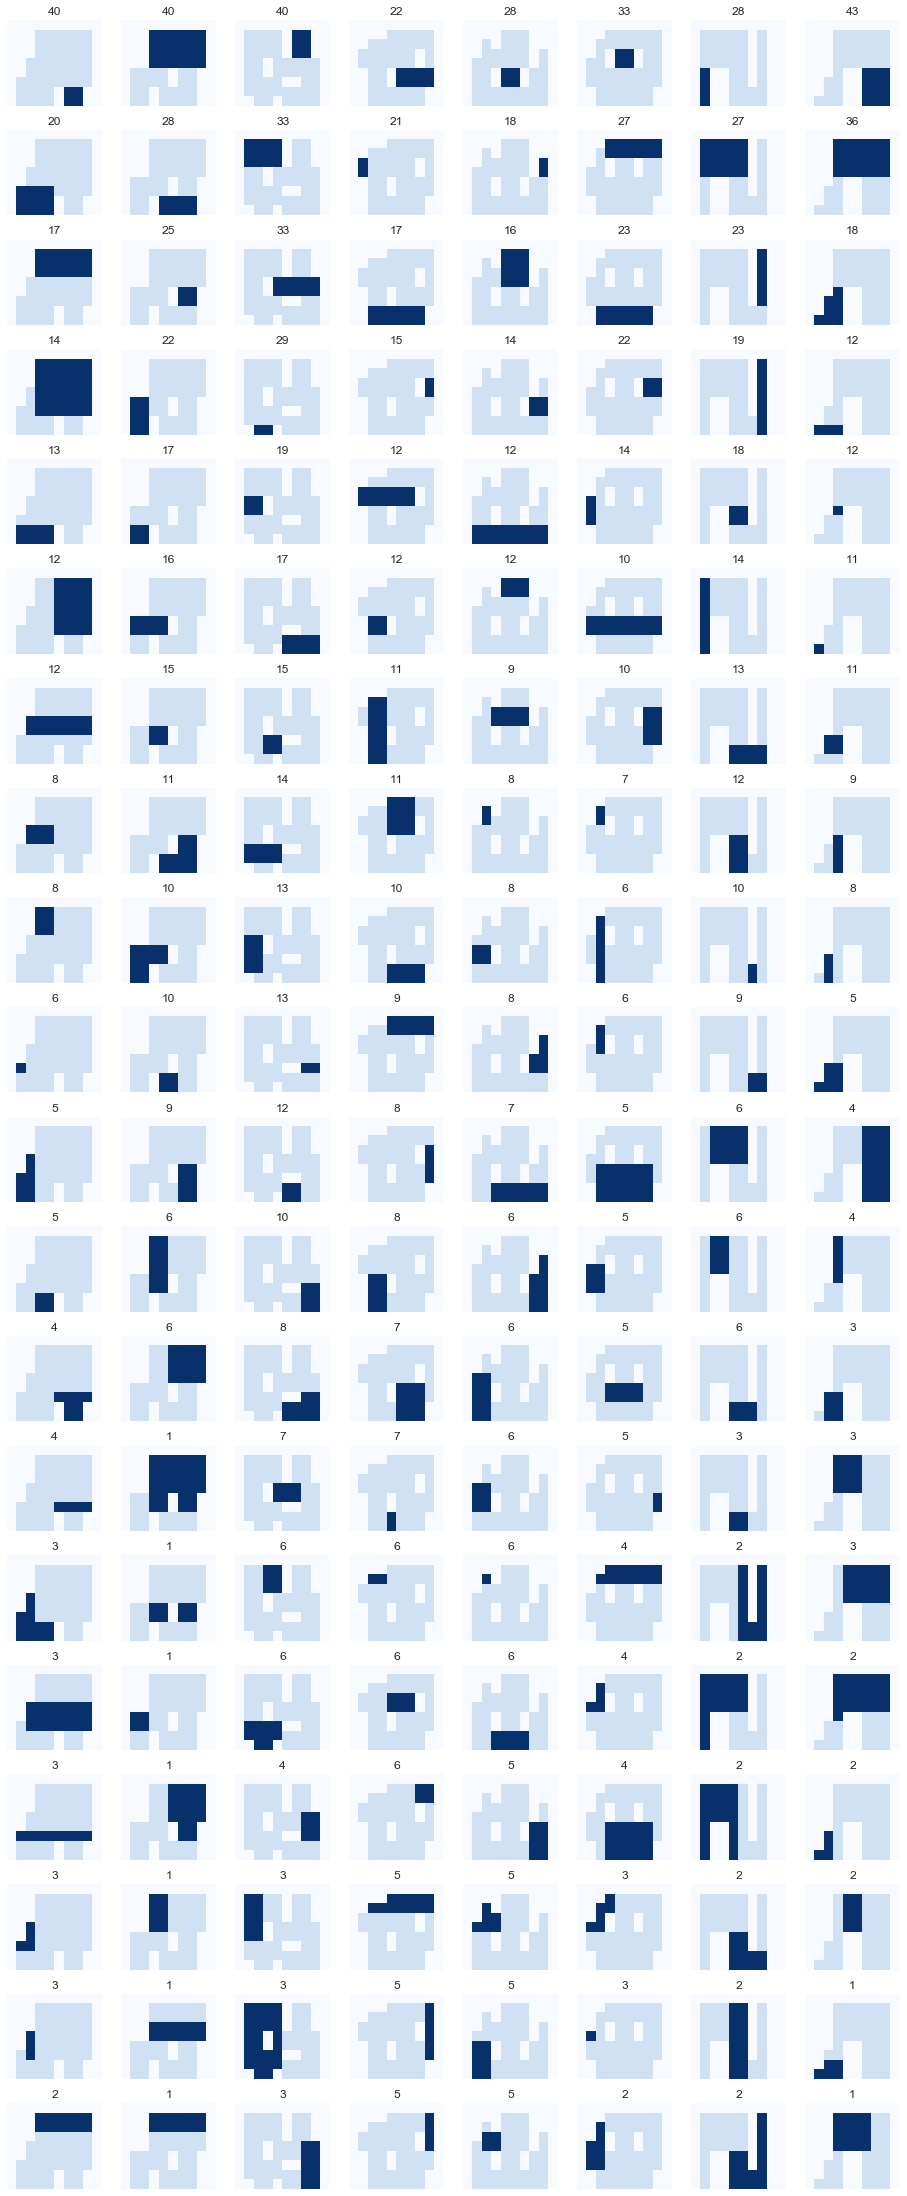

In [749]:
visualize = True

if visualize:

    n_chunks = 20

    fig, axs = plt.subplots(n_chunks, len(targets), figsize=(16,2*n_chunks))

    for i, target in enumerate(targets):
        for j in range(0, n_chunks):
            axs[j,i].axis('off')
            axs[j,i].set_title(str(list(perceptual_chunk_counters[target].values())[j]))
            # label as rectangular or not
            #chunk_str =  str(list(perceptual_chunk_counters[target].keys())[j])
            #axs[j,i].set_title(str(bc.is_rectangle(bc.chunk_str_to_cropped_array(chunk_str))))
            drawing.show_chunk([list(perceptual_chunk_counters[target].keys())[j]], axs[j,i], target=target, cmap='Blues', cropped=True)
            

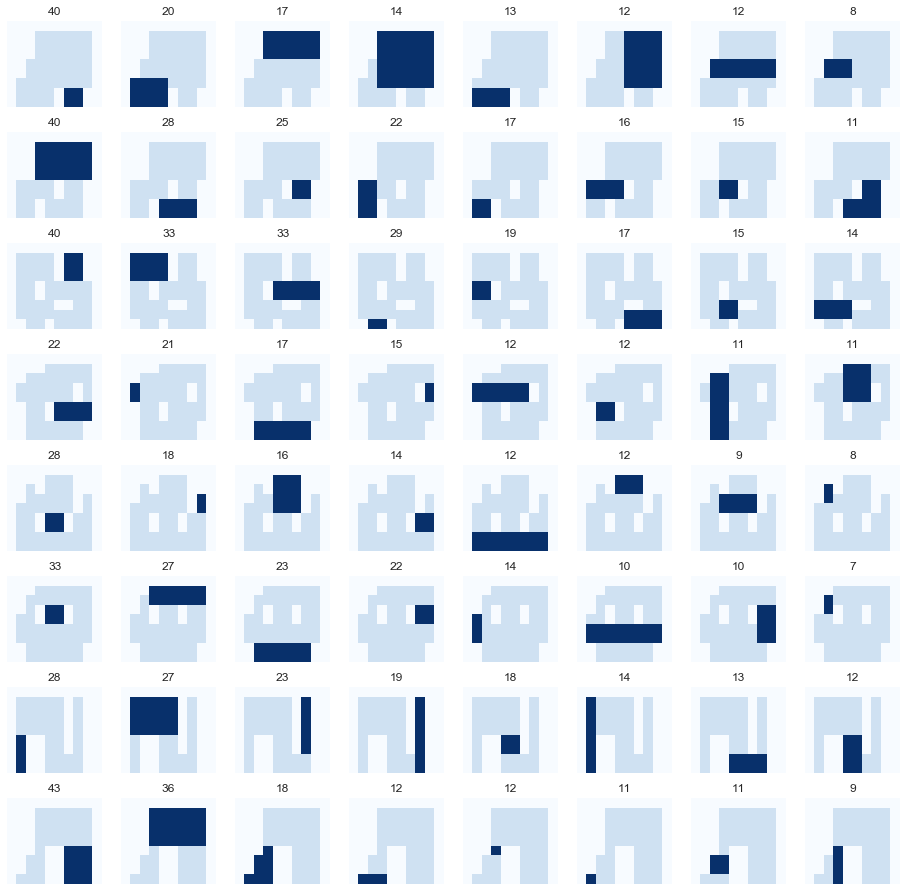

In [748]:
visualize = True

if visualize:

    n_chunks = 8

    fig, axs = plt.subplots(len(targets), n_chunks, figsize=(16,2*n_chunks))

    for i, target in enumerate(targets):
        for j in range(0, n_chunks):
            axs[i,j].axis('off')
            axs[i,j].set_title(str(list(perceptual_chunk_counters[target].values())[j]))
            # label as rectangular or not
            #chunk_str =  str(list(perceptual_chunk_counters[target].keys())[j])
            #axs[j,i].set_title(str(bc.is_rectangle(bc.chunk_str_to_cropped_array(chunk_str))))
            drawing.show_chunk([list(perceptual_chunk_counters[target].keys())[j]], axs[i,j], target=target, cmap='Blues', cropped=True)
            

In [531]:
# pickle.dump(perceptual_chunk_counters, open("perceptual_chunk_counters.p", "wb" ))

In [589]:
# counts = list(perceptual_chunk_counters[target].values())
# plt.bar(x=range(0,len(counts)), height=counts, bins=len(counts))
# # plt.hist(counts, bins=len(counts))

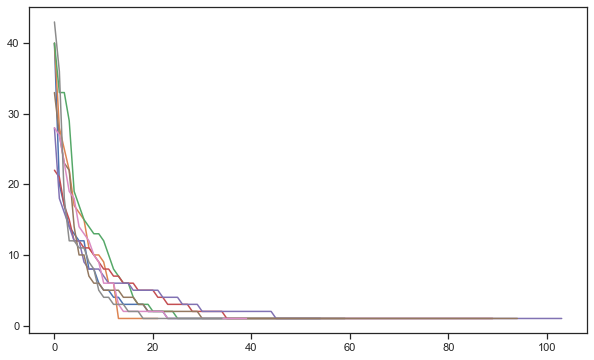

In [697]:
plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
for target in targets:
    plt.plot(list(perceptual_chunk_counters[target].values()))

## Find popular chunks

In [955]:
#### Number of unique chunks per structure
n_unique_chunks_all = {target : len(np.array(list(perceptual_chunk_counters[target].keys()))) for target in targets}
n_unique_chunks_all

{'hand_selected_004': 55,
 'hand_selected_005': 22,
 'hand_selected_006': 60,
 'hand_selected_008': 90,
 'hand_selected_009': 104,
 'hand_selected_011': 95,
 'hand_selected_012': 40,
 'hand_selected_016': 35}

In [956]:
#### Total unique chunks
total_unique_chunks_identified = sum(n_unique_chunks_all.values())
total_unique_chunks_identified

501

In [958]:
prop_chunks_to_include = 0.85

In [943]:
# If choosing chunks by proportion of unique chunks

# prop_chunks_to_include = 0.90

# k = 0

# while sum([len(np.array(list(perceptual_chunk_counters[target].keys()))[0:k]) for target in targets]) < total_unique_chunks_identified*prop_chunks_to_include:
#     k+=1
    
# k

20

In [959]:
# If choosing chunks by proportion of all chunks selected (unique or not)

total_chunks_identified = sum([np.sum(np.array(list(perceptual_chunk_counters[target].values()))) for target in targets])
total_chunks_identified

2114

In [962]:
k = 0

while sum([np.sum(np.array(list(perceptual_chunk_counters[target].values()))[0:k]) for target in targets]) < total_chunks_identified*prop_chunks_to_include:
    k+=1
    
print('top ' + str(k) + ' chunks selected from each tower to cover ' + str(prop_chunks_to_include*100) + '% of all chunks')

top 28 chunks selected from each to cover 85.0% of all chunks


In [335]:
means = []

for target in targets:
    counts = list(perceptual_chunk_counters[target].values())
#     total_chunks = sum(vals)
    means.append(np.mean(counts))

means

[4.054545454545455,
 10.181818181818182,
 5.55,
 3.3333333333333335,
 3.048076923076923,
 2.9789473684210526,
 5.725,
 5.857142857142857]

#### Load in building procedures from block_silhouette, and find all world-deltas for all reconstructions

'world-deltas': change in world state (i.e. squares covered by blocks) between action i and action j, for all i and j.

In [963]:
# load in procedural data from silhouette experiment
silhouette_world_path = os.path.join(silhouette_csv_dir,'procedural_chunks_world_states_{}.p'.format('Exp2Pilot3_all'))
df_proc_world_states = pickle.load(open(silhouette_world_path, "rb" ))


silhouette_trial_path = os.path.join(silhouette_csv_dir,'block_silhouette_{}_good.csv'.format('Exp2Pilot3_all'))
df_proc_trial = pd.read_csv(silhouette_trial_path)

In [964]:
# find world-deltas in procedures
df_proc_chunks = find_world_diffs(df_proc_world_states)

In [965]:
# search for perceptual chunks in world-deltas for each phase
df_occurrences_in_procedures = find_perc_chunks_in_procedures(perceptual_chunk_counters, 
                                                                df_proc_chunks,
                                                                min_count = 0)

In [966]:
# main dataframe for perceptual chunk stats, by phase

properties_to_copy = df_chunk_properties.groupby(['chunk_str','targetName']).first()\
                .reset_index()[['chunk_str','targetName','height','area','rectangular','is_block',
                                                 'which_block']]

df_perceptual_chunks_by_phase = df_occurrences_in_procedures.merge(properties_to_copy, 
                                                          how='left', 
                                                          on=['chunk_str','targetName'], )




In [967]:
out_path = os.path.join(csv_dir,'df_perceptual_chunks_by_phase.csv')
df_perceptual_chunks_by_phase.to_csv(out_path)

In [968]:
# main dataframe for perceptual chunk stats, with both phases aggregated

df_perceptual_chunks = df_perceptual_chunks_by_phase.groupby(['chunk_str','targetName',
                                                             'perceptual_count']).agg(\
                                                n_with_chunk = ('n_with_chunk', 'sum'),
                                                total_reconstructions = ('total_phase_reconstructions','sum'),
                                                area = ('area','first'),
                                                height = ('height','first'),
                                                rectangular = ('rectangular','first'),
                                                both_zero = ('both_zero','first'),
                                                is_block = ('is_block','first'),
                                                which_block = ('which_block','first'),
                                                perceptual_rank = ('perceptual_rank','first')).reset_index()

df_perceptual_chunks['proportion_with_chunk'] = df_perceptual_chunks['n_with_chunk']/\
                                                df_perceptual_chunks['total_reconstructions']

In [969]:
out_path = os.path.join(csv_dir,'df_perceptual_chunks.csv')
df_perceptual_chunks.to_csv(out_path)

In [553]:
# out_path = os.path.join(csv_dir,'df_perceptual_chunks.csv')
# df_perceptual_chunks.to_csv(out_path)

### Chunks with particular properties (overall- not separated by phase)

In [987]:
# filter and sort by most frequently built (in both phases) 
built_top_perceptual = df_perceptual_chunks[(df_perceptual_chunks.n_with_chunk > 0) &
                                             (df_perceptual_chunks.perceptual_rank < k)]\
                            .sort_values(['n_with_chunk'],ascending=False).reset_index()

#### perceptual chunks that occur most frequently in building procedures

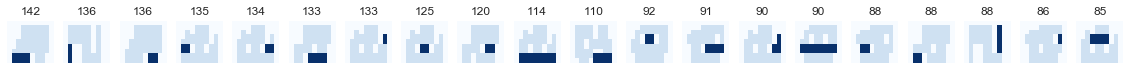

In [1001]:
n_to_view = 20

fig, axs = plt.subplots(1, n_to_view, figsize=(20,2.5*n_to_view))

for i in range(0,n_to_view):
    axs[i].axis('off')
    axs[i].set_title(str(int(built_top_perceptual.loc[i,:].n_with_chunk)))
    drawing.show_chunk([built_top_perceptual.loc[i,:].chunk_str], axs[i], target=built_top_perceptual.loc[i,:].targetName, cmap='Blues', cropped=True)

#### non-rectangular perceptual chunks that occur in building procedures

In [999]:
# find non-rectangular perceptual chunks that wre built at all
# non_rect_chunks = df_perceptual_chunks[(df_perceptual_chunks.n_with_chunk > 0) &
#                      (df_perceptual_chunks.rectangular == 0.)&
#                      (df_perceptual_chunks.perceptual_rank < k)].reset_index().sort_values(['n_with_chunk'])

non_rect_chunks = built_top_perceptual[(built_top_perceptual.rectangular == 0.)].reset_index().sort_values(['n_with_chunk'])



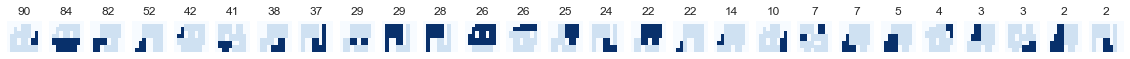

In [1000]:
fig, axs = plt.subplots(1, len(non_rect_chunks), figsize=(20,2.5*len(non_rect_chunks)))

for i, row in non_rect_chunks.iterrows():
    axs[i].axis('off')
    axs[i].set_title(str(int(row.n_with_chunk)))
    drawing.show_chunk([row.chunk_str], axs[i], target=row.targetName, cmap='Blues', cropped=True)

#### (non) block-placement perceptual chunks that occur in building procedures

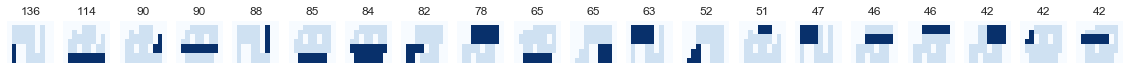

In [1004]:
# Only look at ones that aren't block placements
# non-rectangular perceptual chunks that occur in building procedures

# filter and sort by most frequently built (in both phases) 
built_top_perceptual_not_block = built_top_perceptual[(built_top_perceptual.is_block == False)]\
                        .sort_values(['n_with_chunk'],ascending=False).reset_index()

n_to_view = 20

fig, axs = plt.subplots(1, n_to_view, figsize=(20,2.5*n_to_view))

for i in range(0,n_to_view):
    axs[i].axis('off')
    axs[i].set_title(str(int(built_top_perceptual_not_block.loc[i,:].n_with_chunk)))
    drawing.show_chunk([built_top_perceptual_not_block.loc[i,:].chunk_str], axs[i],
                       target=built_top_perceptual_not_block.loc[i,:].targetName, cmap='Blues', cropped=True)

In [1005]:
not_single_block = len(built_top_perceptual[built_top_perceptual.is_block==1])
single_block = len(built_top_perceptual[built_top_perceptual.is_block==0])

single_block/(not_single_block+single_block)

0.5850340136054422

### Chunk appearance in procedures separated by phase

In [1006]:
df_top_k_phase = df_perceptual_chunks_by_phase[df_perceptual_chunks_by_phase.perceptual_rank < k]

# # by number of times built
# min_occurrences = 3
# df_min_occurrences_phase = df_perceptual_chunks_by_phase[df_perceptual_chunks_by_phase.perceptual_count >= min_occurrences]
# print(len(df_min_occurrences_phase))

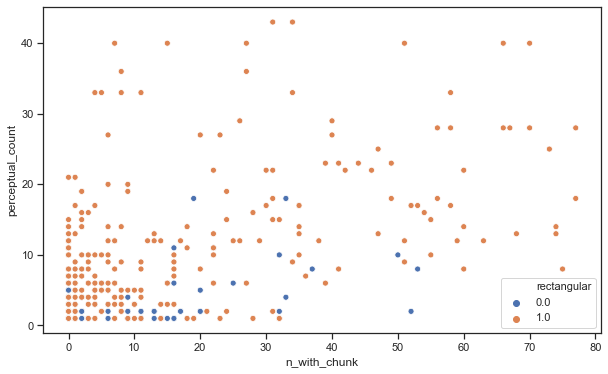

In [1007]:
# Were perceptual chunks built more in the first or final repetition? By structure

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
sns.scatterplot(data=df_top_k_phase, x='n_with_chunk', y='perceptual_count', hue='rectangular')

In [1008]:
df_top_k_phase_built = df_top_k_phase[df_top_k_phase.both_zero==False]

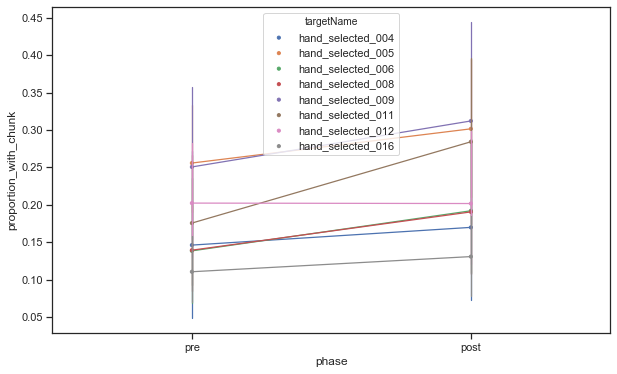

In [1010]:
# Were perceptual chunks built more in the first or final repetition? By structure

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
sns.pointplot(data=df_top_k_phase_built, x='phase', y='proportion_with_chunk', hue='targetName')

<Figure size 1008x720 with 0 Axes>

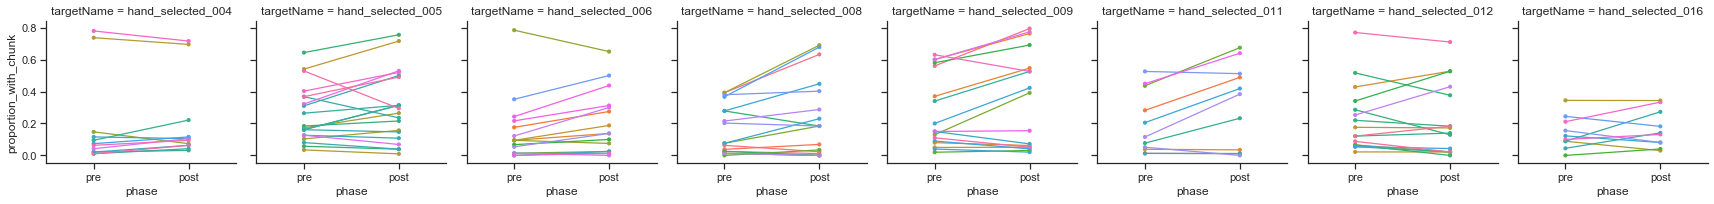

In [733]:
# How many chunks were build more, and how many were built less?

fig = plt.figure(figsize=(14,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(data=df_top_k_phase_built, col="targetName", hue="chunk_str", col_order=targets)
g.map(sns.pointplot,"phase","proportion_with_chunk", order=['pre','post'])

#### Visualize top movers in either direction

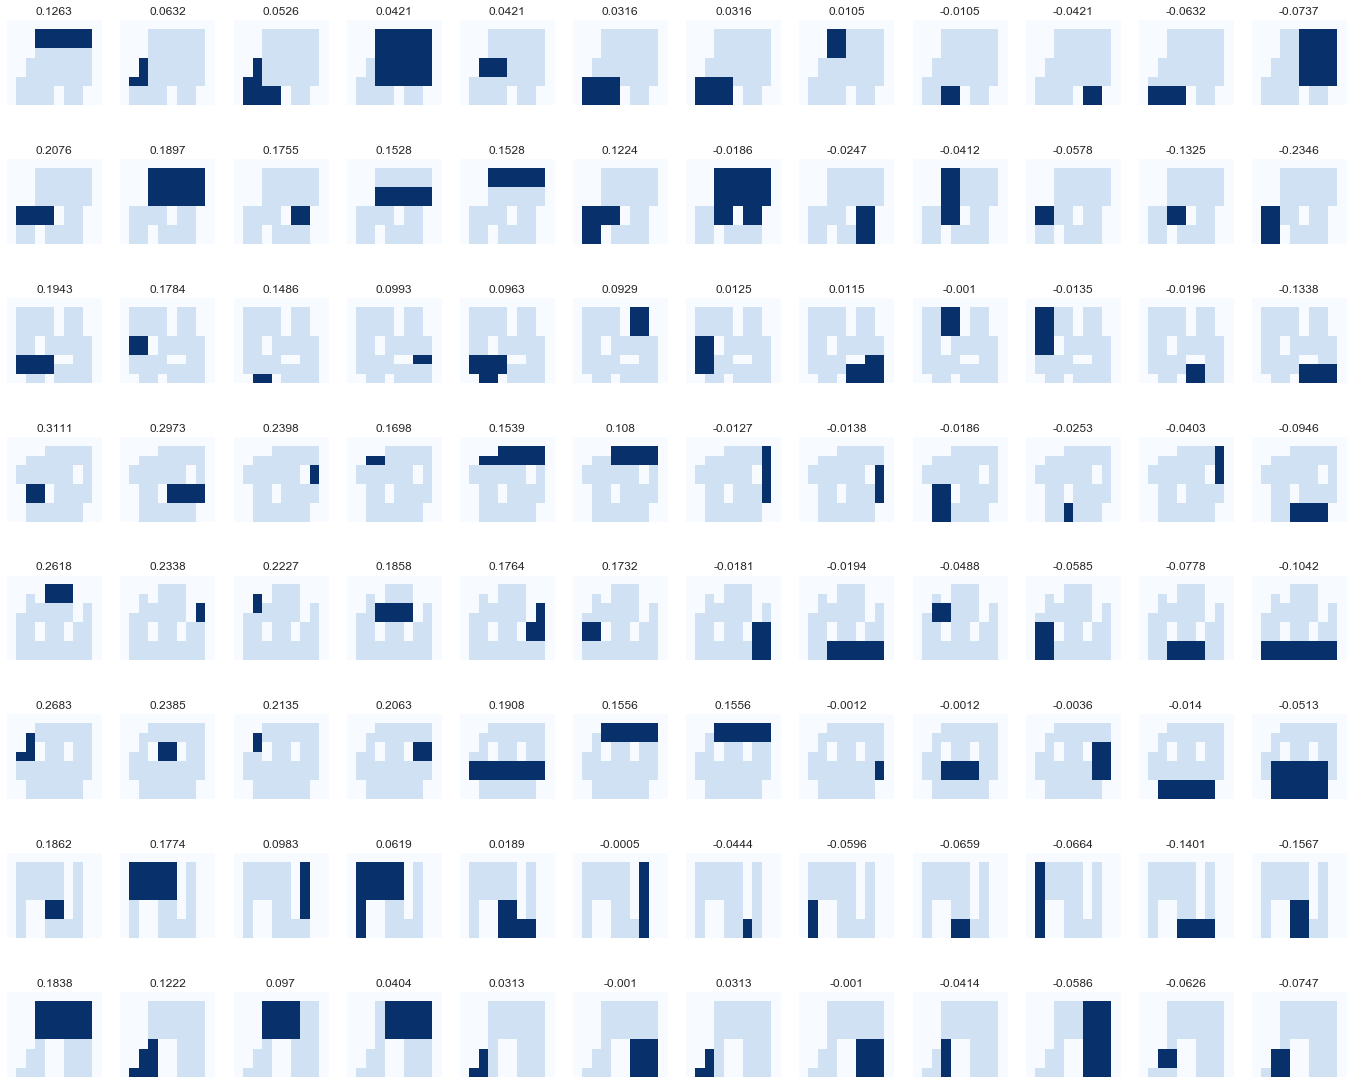

In [736]:
df = df_top_k_phase_built[(df_top_k_phase_built.phase=='pre')]

n_chunks = 6

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df[df.targetName==target].sort_values('difference', ascending=False).reset_index()
        axs[i,j].axis('off')
        axs[i,j].set_title(str((round(greatest_increase.loc[j,'difference'],4))))
        drawing.show_chunk([greatest_increase.loc[j,'chunk_str']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_decrease = df[df.targetName==target].sort_values('difference', ascending=True).reset_index()
        axs[i,n_chunks*2-1-j].axis('off')
        axs[i,n_chunks*2-1-j].set_title(str((round(greatest_decrease.loc[j,'difference'],4))))
        drawing.show_chunk([greatest_decrease.loc[j,'chunk_str']], axs[i,n_chunks*2-1-j], target=target, cmap='Blues', cropped=True)

# <-- Largest increase first to final ... Largest decrease first to final-->

#### Unbuilt popular perceptual chunks

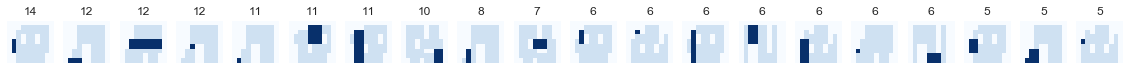

In [1015]:
unbuilt_popular_perceptual = df_perceptual_chunks[(df_perceptual_chunks.n_with_chunk==0.) & 
                                                 (df_perceptual_chunks.perceptual_rank < k)]\
                                .sort_values('perceptual_count', ascending=False).reset_index()


n_top_unbuilt = 20

fig, axs = plt.subplots(1, n_top_unbuilt, figsize=(20,2.5*n_top_unbuilt))

for i in range(0,n_top_unbuilt):
    axs[i].axis('off')
    axs[i].set_title(str(int(unbuilt_popular_perceptual.loc[i,:].perceptual_count)))
    drawing.show_chunk([unbuilt_popular_perceptual.loc[i,:].chunk_str], 
                       axs[i], target=unbuilt_popular_perceptual.loc[i,:].targetName, cmap='Blues', cropped=True)

In [510]:
built_popular_perceptual = df_perceptual_chunks[(df_perceptual_chunks.n_with_chunk>0.) & 
                                                 (df_perceptual_chunks.perceptual_rank<=k)]

In [533]:
prop_unbuilt = len(unbuilt_popular_perceptual)/(len(built_popular_perceptual) + len(unbuilt_popular_perceptual))
prop_built = len(built_popular_perceptual)/(len(built_popular_perceptual) + len(unbuilt_popular_perceptual))

In [534]:
prop_built

0.7261904761904762

In [531]:
prop_unbuilt

0.27380952380952384

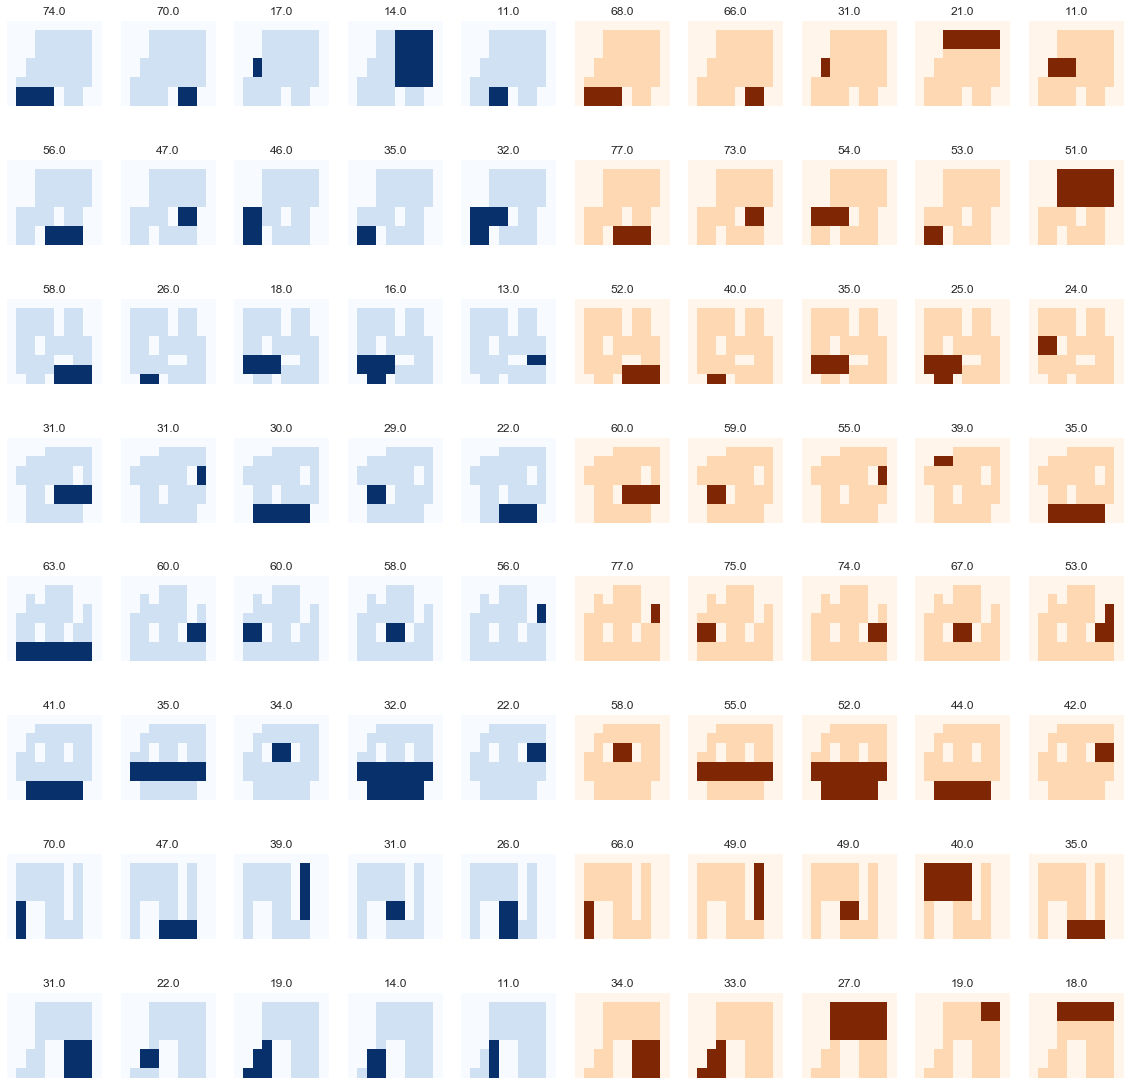

In [1016]:
# Most popular perceptual chunks in each phase

n_chunks = 5

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        most_popular = df_top_k_phase[(df_top_k_phase.targetName==target) &
                                                       (df_top_k_phase.phase=='pre')].sort_values('n_with_chunk', ascending=False).reset_index()
        axs[i,j].set_title(str(round(most_popular.loc[j,'n_with_chunk'],2)))
        axs[i,j].axis('off')
        drawing.show_chunk([most_popular.loc[j,'chunk_str']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        most_popular = df_top_k_phase[(df_top_k_phase.targetName==target) &
                                                       (df_top_k_phase.phase=='post')].sort_values('n_with_chunk', ascending=False).reset_index()
#         axs[i,n_chunks*2-1-j].set_title(str(round(most_popular.loc[j,'built_by_ppt'],2)))
#         axs[i,n_chunks*2-1-j].axis('off')
#         drawing.show_chunk([most_popular.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Reds', cropped=True)
        axs[i,int(j+n_chunks)].set_title(str(round(most_popular.loc[j,'n_with_chunk'],2)))
        axs[i,int(j+n_chunks)].axis('off')
        drawing.show_chunk([most_popular.loc[j,'chunk_str']], axs[i,int(j+n_chunks)], target=target, cmap='Oranges', cropped=True)


<Figure size 1440x720 with 0 Axes>

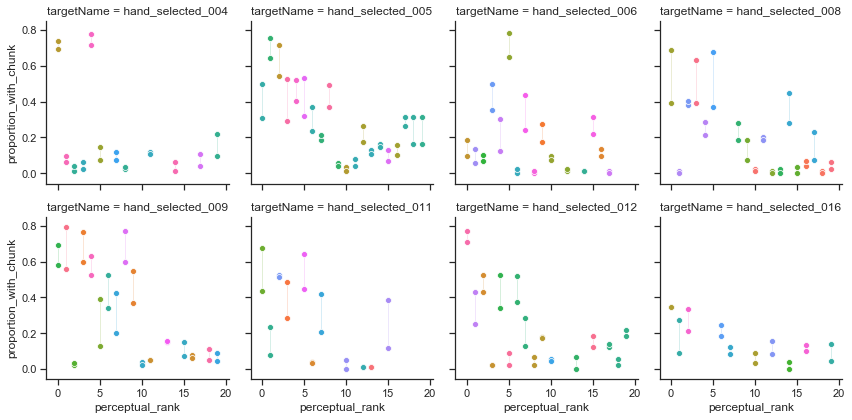

In [739]:
# How many chunks were built more, and how many were built less?

fig = plt.figure(figsize=(20,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 4})
g = sns.FacetGrid(data=df_top_k_phase_built, col="targetName", col_wrap=4, hue="chunk_str", col_order=targets)
g.map(sns.lineplot, "perceptual_rank", "proportion_with_chunk")
g.map(sns.scatterplot, "perceptual_rank", "proportion_with_chunk")



<Figure size 1440x720 with 0 Axes>

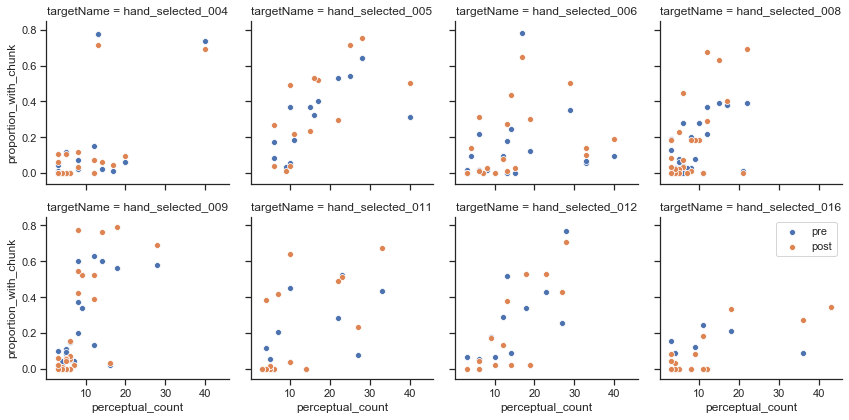

In [465]:
# How many chunks were build more, and how many were built less?

df = df_occurrences_in_procedures[(df_occurrences_in_procedures.perceptual_count > 2)]

fig = plt.figure(figsize=(20,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':True})
sns.set(style="ticks", rc={"lines.linewidth": 4})
g = sns.FacetGrid(data=df, col="targetName", col_wrap=4, hue="phase", col_order=targets)
g.map(sns.scatterplot, "perceptual_count", "proportion_with_chunk")
plt.legend()


In [509]:
target = 'hand_selected_004'
c1 = df_occurrences_in_procedures[(df_occurrences_in_procedures.targetName == target) &
                             (df_occurrences_in_procedures.proportion_with_chunk > 0.6)].chunk_str.iloc[0]

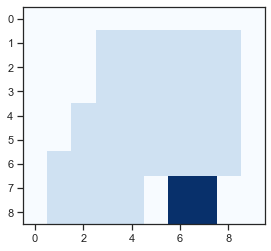

In [510]:
drawing.show_chunk([c1], plt, target=target, cmap='Blues', cropped=True)

In [503]:
target = 'hand_selected_016'
c2 = df_occurrences_in_procedures[(df_occurrences_in_procedures.targetName == target)&
                             (df_occurrences_in_procedures.perceptual_count > 30)].chunk_str.iloc[3]

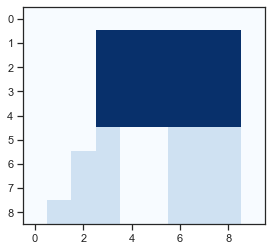

In [504]:
drawing.show_chunk([c2], plt, target=target, cmap='Blues', cropped=True)

In [255]:
df_occurrences_in_procedures

,chunk_height,chunk_str,n_with_chunk,perceptual_count,perceptual_rank,phase,proportion_with_chunk,targetName,total_phase_reconstructions,difference,both_zero
0,1.0,0000000000000000000000000000000000000000000000...,70.0,40.0,0.0,pre,0.736842,hand_selected_004,95.0,-0.042105,False
1,1.0,0000000000000000000000000000000000000000000000...,66.0,40.0,0.0,post,0.694737,hand_selected_004,95.0,-0.042105,False
2,1.5,0000000000000000000000000000000000000000000000...,6.0,20.0,1.0,pre,0.063158,hand_selected_004,95.0,0.031579,False
3,1.5,0000000000000000000000000000000000000000000000...,9.0,20.0,1.0,post,0.094737,hand_selected_004,95.0,0.031579,False
4,6.5,0000000000000000000000000000000000000000000000...,1.0,17.0,2.0,pre,0.010526,hand_selected_004,95.0,0.031579,False
...,...,...,...,...,...,...,...,...,...,...,...
997,2.0,0000000000000000000000000000000000000000000000...,41.0,1.0,32.0,post,0.414141,hand_selected_016,99.0,0.103030,False
998,2.5,0000000000000000000000000000000000000000000000...,0.0,1.0,33.0,pre,0.000000,hand_selected_016,90.0,0.000000,True
999,2.5,0000000000000000000000000000000000000000000000...,0.0,1.0,33.0,post,0.000000,hand_selected_016,99.0,0.000000,True
1000,0.5,0000000000000000000000000000000000000000000000...,0.0,1.0,34.0,pre,0.000000,hand_selected_016,90.0,0.000000,True


In [ ]:
df_occurrences_in_procedures

In [456]:
out_path = os.path.join(csv_dir,'df_perceptual_in_procedures.csv')
df_occurrences_in_procedures.to_csv(out_path)

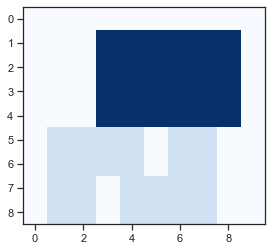

In [153]:
drawing.show_chunk([c], plt, target='hand_selected_005', cmap='Blues', cropped=True)

In [146]:
c = list(perceptual_chunk_counters['hand_selected_005'].keys())[0]

## Integrate chunk information and perceptual rank and count into dataframe

In [811]:
df_chunk_use_separate_phases = pickle.load(open("df_chunk_use_separate_phases_2to6.p", "rb" ))
df_chunk_use_separate_phases['chunk_str'] = df_chunk_use_separate_phases['chunk']

In [812]:
df_chunk_use_separate_phases['chunk_array'] = \
            df_chunk_use_separate_phases['chunk'].apply(bc.chunk_str_to_cropped_array)

df_chunk_use_separate_phases['rectangular'] = df_chunk_use_separate_phases['chunk_array'].apply(lambda chunk: np.bool(bc.is_rectangle(chunk)))
df_chunk_use_separate_phases['is_block'] = df_chunk_use_separate_phases['chunk_array'].apply(lambda chunk: np.bool(bc.could_be_single_block(chunk)[0]))
df_chunk_use_separate_phases['which_block'] = df_chunk_use_separate_phases['chunk_array'].apply(lambda chunk: bc.could_be_single_block(chunk)[1])
df_chunk_use_separate_phases['height'] = df_chunk_use_separate_phases['chunk_array'].apply(lambda chunk: bc.chunk_height(chunk, chunk_is_string=False))
df_chunk_use_separate_phases['area'] = df_chunk_use_separate_phases['chunk_array'].apply(lambda chunk: bc.chunk_area(chunk, chunk_is_string=False))

In [813]:
df_chunk_use_separate_phases

,built_by_ppt,chunk,chunk_source,chunk_window,n_builds_in_training_set,n_phase_recons,phase,prop_containing_chunk,rank,targetName,gameID,perceptual_count,height,area,chunk_str,chunk_array,rectangular,is_block,which_block
0,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,54.0,105.0,pre,0.009524,0.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,0,3.000000,8,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",True,True,"(4, 2)"
1,0.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,44.0,105.0,pre,0.000000,1.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,40,1.000000,4,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",True,True,"(2, 2)"
2,0.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,32.0,105.0,pre,0.000000,2.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,1,5.000000,8,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",True,True,"(4, 2)"
3,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,28.0,105.0,pre,0.009524,3.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,0,2.500000,2,0000000000000000000000000000000000000000000000...,"[[0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, ...",True,True,"(2, 1)"
4,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,23.0,105.0,pre,0.009524,4.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,1,3.000000,4,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",True,True,"(2, 2)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100795,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,5.0,105.0,post,0.000000,7.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,4.000000,18,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, ...",False,False,None
100796,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,5.0,105.0,post,0.000000,8.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,2.142857,14,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",False,False,None
100797,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,4.0,105.0,post,0.000000,9.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,1.500000,12,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, ...",False,False,None
100798,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,4.0,105.0,post,0.000000,10.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,4.000000,20,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",False,False,None


In [1011]:
proc_chunks_with_perc_data = \
    df_chunk_use_separate_phases.merge(\
            df_perceptual_chunks[['chunk_str','targetName','perceptual_count','perceptual_rank']],\
                                       how='left', on=['chunk_str','targetName'])

proc_chunks_with_perc_data['is_top_perceptual_chunk'] = proc_chunks_with_perc_data['perceptual_rank'] < k

out_path = os.path.join(csv_dir,'proc_chunks_with_perc_data.csv')
proc_chunks_with_perc_data.to_csv(out_path)

df = proc_chunks_with_perc_data

<Figure size 720x432 with 0 Axes>

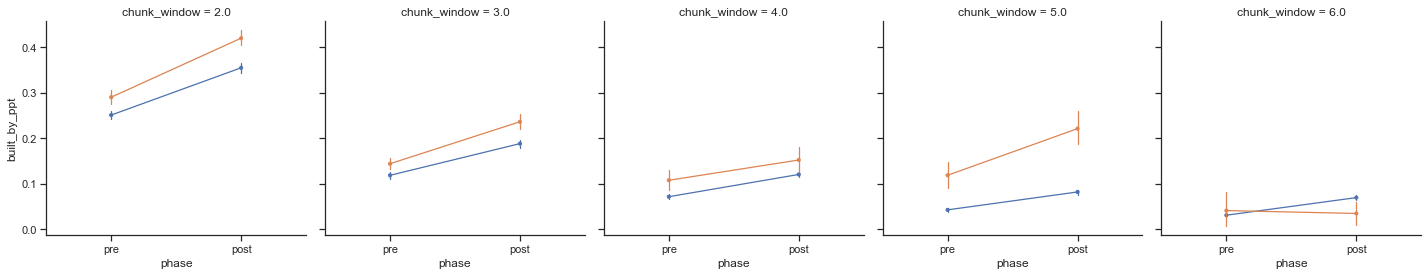

In [1012]:
# How often were most popular chunks built by left-out ppt, by phase, by structure?

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df, col="chunk_window", height=4, hue='is_top_perceptual_chunk')
g.map(sns.pointplot, "phase", "built_by_ppt", order=['pre','post']);

In [1013]:
proc_chunks_with_perc_data

,built_by_ppt,chunk,chunk_source,chunk_window,n_builds_in_training_set,n_phase_recons,phase,prop_containing_chunk,rank,targetName,...,height,area,chunk_str,chunk_array,rectangular,is_block,which_block,perceptual_count_y,perceptual_rank,is_top_perceptual_chunk
0,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,54.0,105.0,pre,0.009524,0.0,hand_selected_004,...,3.000000,8,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",True,True,"(4, 2)",NaN,NaN,False
1,0.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,44.0,105.0,pre,0.000000,1.0,hand_selected_004,...,1.000000,4,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",True,True,"(2, 2)",40.0,0.0,True
2,0.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,32.0,105.0,pre,0.000000,2.0,hand_selected_004,...,5.000000,8,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",True,True,"(4, 2)",1.0,50.0,False
3,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,28.0,105.0,pre,0.009524,3.0,hand_selected_004,...,2.500000,2,0000000000000000000000000000000000000000000000...,"[[0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, ...",True,True,"(2, 1)",NaN,NaN,False
4,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,23.0,105.0,pre,0.009524,4.0,hand_selected_004,...,3.000000,4,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",True,True,"(2, 2)",1.0,54.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100795,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,5.0,105.0,post,0.000000,7.0,hand_selected_016,...,4.000000,18,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, ...",False,False,None,NaN,NaN,False
100796,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,5.0,105.0,post,0.000000,8.0,hand_selected_016,...,2.142857,14,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",False,False,None,NaN,NaN,False
100797,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,4.0,105.0,post,0.000000,9.0,hand_selected_016,...,1.500000,12,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, ...",False,False,None,NaN,NaN,False
100798,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,4.0,105.0,post,0.000000,10.0,hand_selected_016,...,4.000000,20,0000000000000000000000000000000000000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",False,False,None,NaN,NaN,False
